# Notebook for data inspection

Imports

In [1]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import pyBigWig
from Modules import utils, plot_utils

Useful global variables

In [2]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Read checks

Bombyx long reads vs short reads

In [ ]:
with np.load(f'{data_dir}/Bombyx/raw_data/X_long.npz') as f:
    long_reads = f['reads']
with np.load(f'{data_dir}/Bombyx/raw_data/X_reads.npz') as f:
    reads = f['reads']

In [ ]:
total = 0
for i in range(len(long_reads)):
    assert(len(long_reads[i]) == len(long_reads[i].rstrip()))
    total += len(long_reads[i])
print(total)
total2 = 0
for i in range(len(reads)):
    assert(len(reads[i]) == len(reads[i].rstrip()))
    total2 += len(reads[i])
print(total2)

Total number of reads vs number of reads without Ns in training data

In [ ]:
with np.load(f'{data_dir}/RNAPII_quiescence/raw_data/Control_reads.npz') as f:
    reads = f['reads']
print(reads.shape)
# sequences = utils.remove_reads_with_N(reads, tolerance=0)
# print(len(sequences))

(40956444,)


In [22]:
n_valid_per_file = {}
for file in Path(data_dir, 'RNAPII_quiescence', 'raw_data', 'aligned_fastq').glob('*_deduped.fastq'):
    print(file.name)
    with open(file) as f:
        n_valid = 0
        for line in grouper(f, 4):
            _, seq, *_ = line
            seq = seq.rstrip()
            if len(seq) == 51 and 'N' not in seq:
                n_valid += 1
    print(n_valid)
    n_valid_per_file[file.name] = n_valid
for key, value in sorted(n_valid_per_file.items()):
    print(key, value)

WT_6d_IP_1_aligned_deduped.fastq 11070425
WT_6d_IP_2_aligned_deduped.fastq 9688767
WT_expo_IP_1_aligned_deduped.fastq 7282282
WT_expo_IP_2_aligned_deduped.fastq 6698749
untagged_6d_IP_1_aligned_deduped.fastq 4332264
untagged_6d_IP_2_aligned_deduped.fastq 6262499
untagged_expo_IP_1_aligned_deduped.fastq 5366369
untagged_expo_IP_2_aligned_deduped.fastq 4415964


Total number of reads vs number of reads without Ns in post-selected data

In [ ]:
data = 'CENPT'
model_name = 'model_inception2'
threshold = 0.75
with np.load(f'{data_dir}/{data}/results/{model_name}/seqs_{data}_over_{threshold}_with_{model_name}.npz') as f:
    reads = f['reads']
print(reads.shape)
sequences = utils.remove_reads_with_N(reads, tolerance=0)
print(len(sequences))

Read length check

In [ ]:
dico = utils.check_read_lengths(reads)
dico = dict(sorted(dico.items(), reverse=True))
print('{read_length: nb_reads}')
print(dico)

Duplicate checks, in total vs without Ns

In [23]:
sequences = []
with open(Path(data_dir, 'RNAPII_quiescence', 'raw_data', 'aligned_fastq', 'WT_6d_IP_1_aligned_deduped.fastq')) as f:
    n_valid = 0
    for line in grouper(f, 4):
        _, seq, *_ = line
        sequences.append(seq.rstrip())
print('Looking for read duplicates')
dico = utils.find_duplicates(sequences, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

Looking for read duplicates
1 batches
Processing batch 0
seq 11413453/11413453
Looking for duplicate level duplicates
1 batches
Processing batch 0
seq 11413453/11413453 duplicates
{duplicate_level: nb_unique_reads}
{1: 11413453}
top 5 duplicate level reads: [1]


In [ ]:
with np.load(f'{data_dir}/H3K9me3/dataset30M.npz') as f:
    reads = f['x_test']

In [ ]:
# with np.load(f'{data_dir}/HEK293-ZFAT/raw_data/Control_reads_deduped.npz') as f:
#     reads = f['reads']
# print(reads.shape)
# sequences = utils.remove_reads_with_N(reads, tolerance=0)
# print(len(sequences))

print('Looking for read duplicates')
dico = utils.find_duplicates(reads, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
values = list(dico.values())
print('Looking for duplicate level duplicates')
dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
dico2 = dict(sorted(dico2.items(), reverse=True))
print('{duplicate_level: nb_unique_reads}')
print(dico2)
print('top 5 duplicate level reads:', list(dico2.keys())[:5])

# print('Looking for read duplicates')
# dico = utils.find_duplicates(sequences, one_hot=False, batch_size=50_000_000, print_freq=20_000_000)
# values = list(dico.values())
# print('Looking for duplicate level duplicates')
# dico2 = utils.find_duplicates(values, batch_size=100_000_000, print_freq=20_000_000)
# dico2 = dict(sorted(dico2.items(), reverse=True))
# print('{duplicate_level: nb_unique_reads}')
# print(dico2)
# print('top 5 duplicate level reads:', list(dico2.keys())[:5])

Looking for read duplicates
1 batches
Processing batch 0
seq 20000000/40956444 duplicates
seq 40000000/40956444 duplicates
seq 40956444/40956444 duplicates
Looking for duplicate level duplicates
1 batches
Processing batch 0
seq 20000000/39066493 duplicates
seq 39066493/39066493 duplicates
{duplicate_level: nb_unique_reads}
{126: 1, 125: 1, 121: 1, 112: 1, 110: 1, 109: 1, 108: 1, 104: 2, 99: 1, 98: 2, 97: 2, 96: 1, 95: 1, 94: 2, 93: 1, 92: 1, 91: 1, 90: 1, 89: 1, 87: 1, 85: 2, 84: 1, 82: 2, 81: 4, 80: 2, 79: 3, 78: 1, 77: 2, 76: 2, 75: 2, 74: 6, 73: 8, 72: 4, 71: 7, 70: 7, 69: 5, 68: 5, 67: 11, 66: 10, 65: 11, 64: 13, 63: 16, 62: 10, 61: 16, 60: 18, 59: 22, 58: 17, 57: 21, 56: 32, 55: 19, 54: 35, 53: 43, 52: 33, 51: 32, 50: 52, 49: 46, 48: 35, 47: 46, 46: 53, 45: 53, 44: 61, 43: 86, 42: 87, 41: 89, 40: 88, 39: 105, 38: 101, 37: 122, 36: 142, 35: 152, 34: 173, 33: 171, 32: 203, 31: 197, 30: 230, 29: 261, 28: 315, 27: 326, 26: 388, 25: 389, 24: 457, 23: 529, 22: 573, 21: 705, 20: 804, 19:

In [ ]:
selected_reads = [k for k, v in dico.items() if v == 110]
print(selected_reads)
print(dico[selected_reads[0]])

['CAGACTTTACAAACAGAGTGTTTCCTAACTGCTCTATGAAAAGAAAGGTTAAACTCTGTGAGTTGAACGCACACATCACAAAGGAGTTTCTGAGAATCATT']
110


Human telomere sequences check

In [ ]:
# human telomere sequences
seq_list = [
    'CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC',
    'CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA',
    'CCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTA',
    'ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCT',
    'TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACC',
    'AACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCC',
    'GGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTA',
    'GTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAG',
    'TTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGG',
    'TAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGG',
    'AGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGT',
    'GGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTTAGGGTT'
]
for seq in seq_list:
    if seq in dico.keys():
        print(dico[seq], seq)
    else:
        print(0, seq)

Plot duplicate levels

In [ ]:
x = list(dico.keys())
y = list(dico.values())
plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('occurences')
plt.xlabel('duplicate level')
plt.show()
plt.close()

Inspect simple dataset labels

In [ ]:
with np.load(f'{data_dir}/Judith-H3K9me3/dataset.npz') as dataset:
    y_train = dataset['y_train']
    y_valid = dataset['y_valid']
    y_test = dataset['y_test']
print('total number of reads:',len(y_train) + len(y_valid) + len(y_test))
print('train:', len(y_train), 'valid:', len(y_valid), 'test:', len(y_test))
print('pos_train:', len(y_train[y_train == 1]), 'pos_valid', len(y_valid[y_valid == 1]), 'pos_test', len(y_test[y_test == 1]))

total number of reads: 60000000
train: 42000000 valid: 9000000 test: 9000000
pos_train: 21000000 pos_valid 4500000 pos_test 4500000


Inspect sharded dataset

In [51]:
with np.load(f'{data_dir}/RNAPII_quiescence/sharded_dataset_expo_1/train_0.npz') as f:
    ids = f['ids']
    one_hots = f['one_hots']

In [52]:
print(ids.shape)
print(one_hots.shape)
counter = 0
for i, val in zip(ids, one_hots):
    if counter > 10:
        break
    print(i, utils.one_hot_decode(val))
    counter += 1
# 9446118

(13859398,)
(13859398, 51, 4)
@SN7001339:1136:HYNMWBCX2:1:2110:8679:12929 CATCCACTGAACTCGCTTCTCAAGAACAAGAAACCAAAGAAGACTCTGCGC
@SN7001339:1137:HYNJFBCX2:1:1202:1765:77263 CGATACACAAGATGACACCGACACCTTGACCTAAAGCGAACTTGGTCTTGT
@SN7001339:1136:HYNMWBCX2:1:2115:4809:49726 CATCCACTGAACTCGCTTCTCAAGAACAAGAAACCAAAGAAGACTCTGCGC
@SN7001339:1137:HYNJFBCX2:1:1101:3224:76267 GATACACAAGATGACACCGACACCTTGACCTAAAGCGAACTTGGTCTTGTC
@SN7001339:1136:HYNMWBCX2:1:2213:4362:66824 CATCCACTGAACTCGCTTCTCAAGAACAAGAAACCAAAGAAGACTCTGCGC
@SN7001339:1137:HYNJFBCX2:1:1104:7839:96051 GACAAGACCAAGTTCGCTTTAGGTCAAGGTGTCGGTGTCATCTTGTGTATC
@SN7001339:1136:HYNMWBCX2:1:2215:9413:72098 CATCCACTGAACTCGCTTCTCAAGAACAAGAAACCAAAGAAGACTCTGCGC
@SN7001339:1137:HYNJFBCX2:1:2111:3495:87019 GACAAGACCAAGTTCGCTTTAGGTCAAGGTGTCGGTGTCATCTTGTGTATC
@SN7001339:1136:HYNMWBCX2:2:1104:18310:93459 CATCCACTGAACTCGCTTCTCAAGAACAAGAAACCAAAGAAGACTCTGCGC
@SN7001339:1137:HYNJFBCX2:2:1109:6328:12270 GACAAGACCAAGTTCGCTTTAGGTCAAGGTGTCGGTGTCATCTTGTGTATC
@SN700133

In [7]:
with np.load(Path('..', 'shared_folder', 'RNAPII_quiescence', 'sharded_dataset_6d_2', 'test_0.npz')) as f:
    read_length = f['one_hots'].shape[1]
print(read_length)

51


In [190]:
with np.load(Path('..', 'shared_folder', 'RNAPII_quiescence', 'sharded_dataset_6d_2', 'test_0.npz')) as f:
    one_hot = f['one_hots'][0]
one_hot.shape

(51, 4)

In [199]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz')) as f:
    for key in f.keys():
        print(key)

chr01
chr02
chr03
chr04
chr05
chr06
chr07
chr08
chr09
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chM
p2


In [46]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'sacCer3.npz')) as f:
    for key in f.keys():
        print(key)

chrI
chrII
chrIII
chrIV
chrIX
chrV
chrVI
chrVII
chrVIII
chrX
chrXI
chrXII
chrXIII
chrXIV
chrXV
chrXVI
chrM


In [6]:
hg38_chr_names = {
    1: 'NC_000001.11',
    2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10'}
for chr_id in hg38_chr_names.keys():
    # load one_hot_encoded sequence
    genome_file = f'{data_dir}/Human/assembly/GRCh38/chr{chr_id}.npz'
    with np.load(genome_file) as f:
        one_hot = f['one_hot_genome']
        print(chr_id, one_hot.shape)

1 (248956422, 4)
2 (242193529, 4)
3 (198295559, 4)
4 (190214555, 4)
5 (181538259, 4)
6 (170805979, 4)
7 (159345973, 4)
8 (145138636, 4)
9 (138394717, 4)
10 (133797422, 4)
11 (135086622, 4)
12 (133275309, 4)
13 (114364328, 4)
14 (107043718, 4)
15 (101991189, 4)
16 (90338345, 4)
17 (83257441, 4)
18 (80373285, 4)
19 (58617616, 4)
20 (64444167, 4)
21 (46709983, 4)
22 (50818468, 4)
X (156040895, 4)
Y (57227415, 4)


In [8]:
with open(Path(data_dir, 'Judith-H3K9me3', 'results', 'model_inception3.1', 'read_ids_Judith-H3K9me3_over_0.55_with_model_inception3.1.txt')) as f:
    dico = {}
    for line in f:
        id_part, *_ = line.split(' ')
        if id_part in dico.keys():
            dico[id_part] += 1
        else:
            dico[id_part] = 1
    print(len(dico))

637229


In [203]:
file = Path(data_dir, 'SCerevisiae', 'data', 'Yeast-myco_MNase_exp.bw')
# Load MNase signal by chromosome into a dictionnary
bw = pyBigWig.open(str(file))
chr_values = {}
for chr_id in bw.chroms().keys():
    chr_values['chr' + format(utils.roman_to_int(chr_id[3:]), '02d')] = bw.values(chr_id, 0, -1, numpy=True)
    # chr_values[chr_id] = bw.values(chr_id, 0, -1, numpy=True)

# Get step corresponding to a single count
all_values = np.concatenate([val for val in chr_values.values()])
step = np.unique(all_values)[1]

for key, val in chr_values.items():
    # Transform signal into counts
    val = np.round(val / step)
    # Remove first count of each pair
    val = np.insert(np.diff(np.cumsum(val) // 2), 0, 0)
    # Clip to a maximum of 65 counts
    val = np.clip(val, a_min=None, a_max=65)
    # Apply gaussian smoothing
    chr_values[key] = np.convolve(val, scipy.signal.windows.gaussian(100, 15), mode='same')

# Clip to 99th percentile and normalize in [0, 1]
all_values = np.concatenate([val for val in chr_values.values()])
quant99 = np.quantile(all_values, 0.99)
for key, value in chr_values.items():
    chr_values[key] = np.clip(value, None, quant99) / quant99

# Save in npz format
save_file = utils.safe_filename(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz'))
np.savez_compressed(save_file, **chr_values)

In [201]:
for chr_id in bw.chroms().keys():
    a = bw.values(chr_id, 0, -1, numpy=True)
    print(chr_id, a.shape)

chrI (252221,)
chrII (844051,)
chrIII (341087,)
chrIV (1575129,)
chrV (572496,)
chrVI (277781,)
chrVII (1092105,)
chrVIII (564939,)
chrIX (430780,)
chrX (762303,)
chrXI (683383,)
chrXII (1084257,)
chrXIII (929095,)
chrXIV (793416,)
chrXV (1108329,)
chrXVI (986200,)


In [202]:
for chr_id, value in chr_values.items():
    print(chr_id, value.shape)

chr01 (252320,)
chr02 (844150,)
chr03 (341186,)
chr04 (1575228,)
chr05 (572595,)
chr06 (277880,)
chr07 (1092204,)
chr08 (565038,)
chr09 (430879,)
chr10 (762402,)
chr11 (683482,)
chr12 (1084356,)
chr13 (929194,)
chr14 (793515,)
chr15 (1108428,)
chr16 (986299,)


In [47]:
corrs = {}
diff_len = {}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase2.npz')) as f2:
        for chr_id in f.keys():
            labels = f[chr_id]
            labels2 = f2[chr_id]
            assert len(labels) == len(labels2)
            chr_roman = 'chr' + utils.int_to_roman(int(chr_id[3:]))
            labels_max = np.load(Path(data_dir, 'SCerevisiae', 'data', f'W303_lab_{chr_roman}.npy'))
            diff_len[chr_id] = len(labels) - len(labels_max)
            labels, labels_max = utils.adjust_length(labels, labels_max)
            assert len(labels) == len(labels2)
            corrs[chr_id] = np.corrcoef([labels, labels2, labels_max])
corrs

{'chr01': array([[1.        , 0.99452457, 0.99452414],
        [0.99452457, 1.        , 0.99999966],
        [0.99452414, 0.99999966, 1.        ]]),
 'chr02': array([[1.        , 0.99504285, 0.99504168],
        [0.99504285, 1.        , 0.99999895],
        [0.99504168, 0.99999895, 1.        ]]),
 'chr03': array([[1.        , 0.99355306, 0.99355275],
        [0.99355306, 1.        , 0.99999975],
        [0.99355275, 0.99999975, 1.        ]]),
 'chr04': array([[1.        , 0.99556177, 0.99556165],
        [0.99556177, 1.        , 0.99999991],
        [0.99556165, 0.99999991, 1.        ]]),
 'chr05': array([[1.        , 0.99567985, 0.99567846],
        [0.99567985, 1.        , 0.99999882],
        [0.99567846, 0.99999882, 1.        ]]),
 'chr06': array([[1.        , 0.9926761 , 0.99267445],
        [0.9926761 , 1.        , 0.99999861],
        [0.99267445, 0.99999861, 1.        ]]),
 'chr07': array([[1.        , 0.99624121, 0.99536772],
        [0.99624121, 1.        , 0.99963779],
     

In [45]:
diff_len

{'chr01': 93,
 'chr02': 91,
 'chr03': 69,
 'chr04': 69,
 'chr05': 67,
 'chr06': 83,
 'chr07': 108,
 'chr08': 95,
 'chr09': 68,
 'chr10': 64,
 'chr11': 60,
 'chr12': 74,
 'chr13': 66,
 'chr14': 92,
 'chr15': 70,
 'chr16': 69}

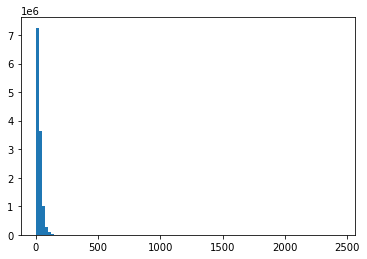

In [183]:
plt.hist(all_values, bins=100)
plt.show()
plt.close()

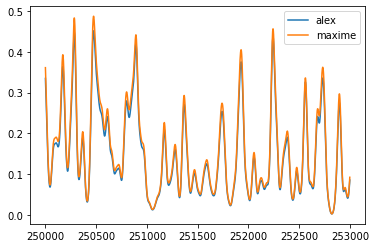

In [48]:
chr_id = 'chr01'
start = 250_000 # 102_200 #
stop = start + 3000 # len(chr_values[chr_id]) #
plt.plot(np.arange(start, min(stop, len(labels))), labels2[start:stop], label='alex')
plt.plot(np.arange(start, min(stop, len(labels_max))), labels_max[start:stop], label='maxime')
plt.legend()
plt.show()
plt.close()

In [61]:
chr_labels = []
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    for chr_id in f.keys():
        chr_labels.append(f[chr_id])
chr_labels = np.concatenate(chr_labels)

chr_labels2 = []
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase2.npz')) as f:
    for chr_id in f.keys():
        chr_labels2.append(f[chr_id])
chr_labels2 = np.concatenate(chr_labels2)

chr_labels3 = []
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase3.npz')) as f:
    for chr_id in f.keys():
        chr_labels3.append(f[chr_id])
chr_labels3 = np.concatenate(chr_labels3)

chr_labels4 = []
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase4.npz')) as f:
    for chr_id in f.keys():
        chr_labels4.append(f[chr_id])
chr_labels4 = np.concatenate(chr_labels4)

chr_labels5 = []
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase5.npz')) as f:
    for chr_id in f.keys():
        chr_labels5.append(f[chr_id])
chr_labels5 = np.concatenate(chr_labels5)

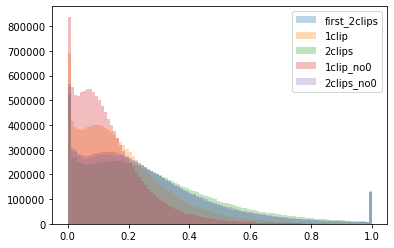

In [63]:
plt.hist(chr_labels, bins=100, alpha=0.3, label='first_2clips')
plt.hist(chr_labels2, bins=100, alpha=0.3, label='1clip')
plt.hist(chr_labels3, bins=100, alpha=0.3, label='2clips')
plt.hist(chr_labels4, bins=100, alpha=0.3, label='1clip_no0')
plt.hist(chr_labels5, bins=100, alpha=0.3, label='2clips_no0')
plt.legend()
plt.show()
plt.close()

In [131]:
np.where((a[:-2] == 0) & (a[1:-1] == step) & (a[2:] == 0))[0]

array([], dtype=int64)

Script for merging Maxime's label files into one

In [5]:
all_chr = {}
for i in range(1, 20):
    chr_id = f'chr{i}'
    arr = np.load(Path(data_dir, 'MMusculus', 'data', 'MNase', 'multimappers', 'A', f'chr{i}.npy'))
    with np.load(Path(data_dir, 'MMusculus', 'genome', 'mm10.npz')) as f:
        chr_len = len(f[chr_id])
    all_chr[chr_id] = np.append(arr, np.zeros(chr_len - len(arr)))
    print(chr_id, chr_len, arr.shape, len(all_chr[chr_id]))
    

chr1 195471971 (195320774,) 195471971
chr2 182113224 (182003883,) 182113224
chr3 160039680 (159938582,) 160039680
chr4 156508116 (156256030,) 156508116
chr5 151834684 (151733687,) 151834684
chr6 149736546 (149585589,) 149736546
chr7 145441459 (145340080,) 145441459
chr8 129401213 (129272910,) 129401213
chr9 124595110 (124494048,) 124595110
chr10 130694993 (130542088,) 130694993
chr11 122082543 (121981260,) 122082543
chr12 120129022 (120023883,) 120129022
chr13 120421639 (120320529,) 120421639
chr14 124902244 (124739579,) 124902244
chr15 104043685 (103814558,) 104043685
chr16 98207768 (97996489,) 98207768
chr17 94987271 (94886285,) 94987271
chr18 90702639 (90601288,) 90702639
chr19 61431566 (61330356,) 61431566


In [6]:
np.savez_compressed(Path(data_dir, 'MMusculus', 'data', 'MNase', 'multimappers', 'A', 'Maxime_MNase.npz'),
                    **all_chr)

In [7]:
with np.load(Path(data_dir, 'MMusculus', 'data', 'MNase', 'multimappers', 'A', 'Maxime_MNase.npz')) as f:
    all_chr = {}
    for key in f.keys():
        all_chr[key] = f[key]
        print(key, len(all_chr[key]))
all_chr = np.concatenate([v for v in all_chr.values()])

chr1 195471971
chr2 182113224
chr3 160039680
chr4 156508116
chr5 151834684
chr6 149736546
chr7 145441459
chr8 129401213
chr9 124595110
chr10 130694993
chr11 122082543
chr12 120129022
chr13 120421639
chr14 124902244
chr15 104043685
chr16 98207768
chr17 94987271
chr18 90702639
chr19 61431566


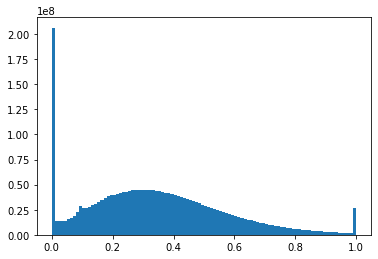

In [10]:
plt.hist(all_chr, bins=100)
plt.show()
plt.close()

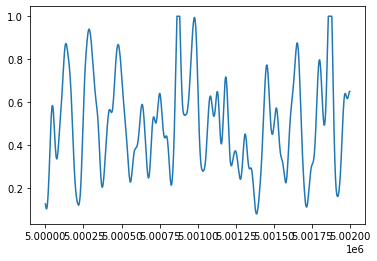

In [18]:
start = 5_000_000
stop = start + 2000
plt.plot(np.arange(start, stop), all_chr[start:stop])
plt.show()
plt.close()

In [15]:
np.argmax(all_chr != 0)

3000078